In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
cd '/content/gdrive/My Drive/VIP_Project'

/content/gdrive/My Drive/VIP_Project


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pylab as plt

In [ ]:
num_epoch = 100
batch_size = 1000

in_timesteps  = range(0,19)
out_timesteps = range(1,20)

# prepare data
data = np.load( "moving-shapes-2-tr-images.npy" )

# training set
x_tr = data[:5000,in_timesteps]
y_tr = data[:5000,out_timesteps]
tr_set = data[0:5000, :, :, :]

# validation set
x_te = data[5000:6000,in_timesteps]
y_te = data[5000:6000,out_timesteps]
te_set = data[5000:6000, :, :, :]

#print (np.shape(x_tr), np.shape(y_tr), np.shape(x_te), np.shape(y_te))
print (np.shape(x_te), np.shape(y_te))

(1000, 19, 64, 64, 3) (1000, 19, 64, 64, 3)


In [ ]:
#CONVLSTM_EN_DE
# from keras.models import Sequential, Model
# from keras.layers import Input, Add, Conv2D, Conv3D, Concatenate, ConvLSTM2D, BatchNormalization, LeakyReLU, MaxPooling2D, UpSampling2D, TimeDistributed

# def mainmodel():
#   # Inputs
#   dtype='float32'  
#   contentInput = Input(shape=(None, 64, 64, 3), dtype=dtype)

#   #Encoding Network
#   x1 = ConvLSTM2D(128, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal')(contentInput)
#   x2 = ConvLSTM2D(64, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal')(x1) 
#   x3 = ConvLSTM2D(64, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal')(x2) 

#   #Forecasting Network
#   x4 = ConvLSTM2D(128, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal')(x1)
#   x5 = ConvLSTM2D(64, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal')(x2)
#   x6 = ConvLSTM2D(64, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal')(x3)

#   #Prediction Network
#   conc = Concatenate()([x4, x5, x6]) #
#   predictions = Conv3D(3, (5,5,5), activation='sigmoid', padding='same')(conc) #sigmoid original

#   model = Model(inputs=contentInput, outputs=predictions)
  
#   model.compile(optimizer='adam', loss='binary_crossentropy')
#   return model

In [ ]:
#Conv3D_EN_DE
from keras.models import Sequential, Model
from keras.layers import Input, Add, Conv2D, Conv3D, Concatenate, ConvLSTM2D, BatchNormalization, LeakyReLU, MaxPooling2D, UpSampling2D, TimeDistributed

def mainmodel():
  # Inputs
  dtype='float32'  
  contentInput = Input(shape=(None, 64, 64, 3), dtype=dtype)

  #Encoding Network
  x1 = Conv3D(filters=128, kernel_size=(5, 5, 5), activation="relu", padding="same")(contentInput)
  x2 = Conv3D(filters=64, kernel_size=(5, 5, 5), activation="relu", padding="same")(x1)
  x3 = Conv3D(filters=64, kernel_size=(5, 5, 5), activation="relu", padding="same")(x2)

  #Forecasting Network
  x4 = Conv3D(filters=128, kernel_size=(5, 5, 5), activation="relu", padding="same")(x1)
  x5 = Conv3D(filters=64, kernel_size=(5, 5, 5), activation="relu", padding="same")(x2)
  x6 = Conv3D(filters=64, kernel_size=(5, 5, 5), activation="relu", padding="same")(x3)

  #Prediction Network
  conc = Concatenate()([x4, x5, x6]) #
  predictions = Conv3D(3, (5,5,5), activation='sigmoid', padding='same')(conc) #sigmoid original

  model = Model(inputs=contentInput, outputs=predictions)
  
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model

In [ ]:
seq = mainmodel()
seq.load_weights('conv3d_shapes_checkpoint_generator') #Epoch 1
seq.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 64, 64 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, None, 64, 64, 48128       input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, None, 64, 64, 1024064     conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, None, 64, 64, 512064      conv3d_1[0][0]                   
_______________________________________________________________________________________

In [ ]:
def generator(X, y, batch_size):
    while True:
        for start in range(0, len(X), batch_size):
            end = min(start + batch_size, len(X))
            yield np.array(X[start:end]/255), np.array(y[start:end]/255)

In [ ]:
batch_size=12

checkpoint_filepath = 'conv3d_shapes_checkpoint_generator'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
  )

history = seq.fit_generator(
    generator(x_tr, y_tr, batch_size),
    steps_per_epoch = len(x_tr)/batch_size,
    epochs=5, 
    verbose=1,
    validation_data=generator(x_te, y_te, batch_size),
    validation_steps = len(x_te)/batch_size,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/5
417/416 [==============================] - ETA: -5s - loss: 0.1393
Epoch 00001: val_loss improved from inf to 0.12817, saving model to conv3d_shapes_checkpoint_generator
417/416 [==============================] - 6834s 16s/step - loss: 0.1393 - val_loss: 0.1282
Epoch 2/5
417/416 [==============================] - ETA: -5s - loss: 0.1277
Epoch 00002: val_loss improved from 0.12817 to 0.12591, saving model to conv3d_shapes_checkpoint_generator
417/416 [==============================] - 6788s 16s/step - loss: 0.1277 - val_loss: 0.1259
Epoch 3/5
417/416 [==============================] - ETA: -5s - loss: 0.1261
Epoch 00003: val_loss improved from 0.12591 to 0.12482, saving model to conv3d_shapes_checkpoint_generator
417/416 [==============================] - 6781s 16s/step - loss: 0.1261 - val_loss: 0.1248
Epoch 4/5
417/416 [==============================] - ETA: -5s - loss: 0.1255
Epoch 00004: val_loss improved from 0.12482 to 0.12419, saving model to conv3d_shapes_checkpoint_ge

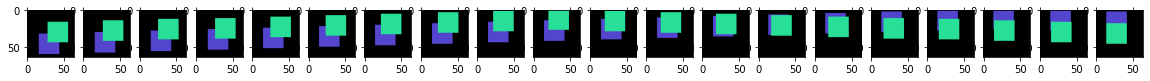

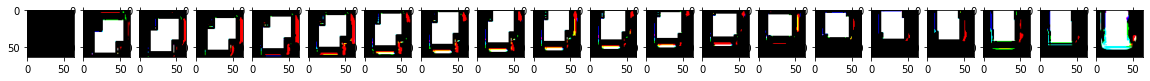

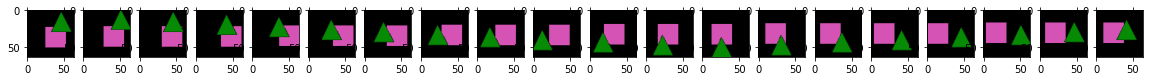

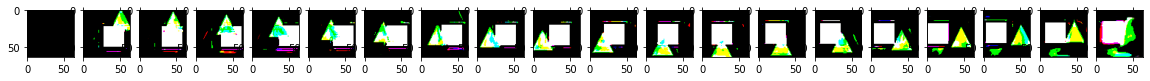

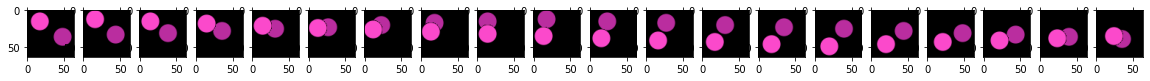

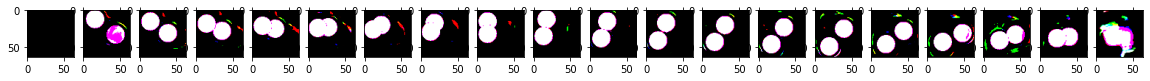

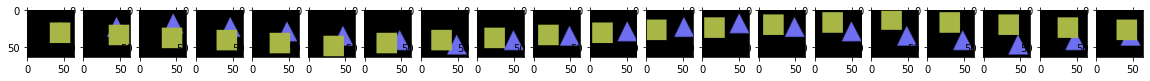

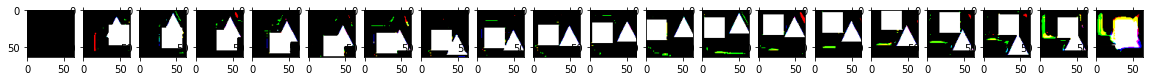

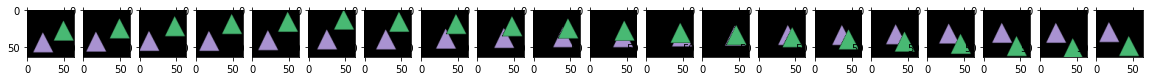

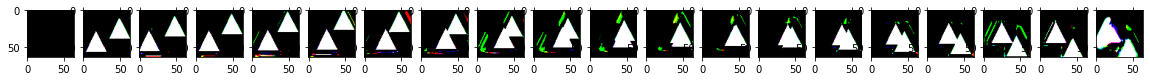

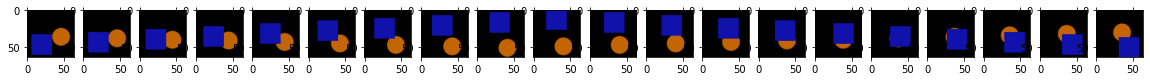

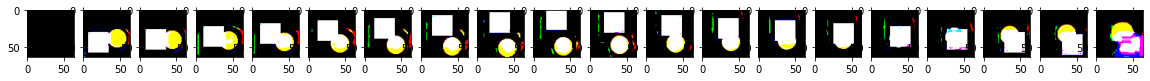

In [ ]:
for sequence in range(1,7,1):
    track = x_te[sequence, :20, ::, ::, ::]
    y_prediction = seq.predict(track[np.newaxis])
    #print(y_prediction.shape)
    # ground truth
    plt.figure(figsize=(20,10))
    for i in range(20):
        plt.subplot(1, 20, i+1)
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(te_set[sequence,i,:,:,:])

    # prediction
    plt.figure(figsize=(20,10))
    plt.subplot(1,20,1)
    plt.imshow(np.zeros((64,64,3)))
    for i in range(19):
        plt.subplot(1, 20, i+2) 
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(y_prediction[0,i,:,:,:])

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_float32

te_set = img_as_float32(te_set)
y_prediction = seq.predict(x_te[:, :20, ::, ::, ::])

mse=0
mae=0
ssim_v=0

for i in range(batch_size):
  mse_i=0
  mae_i=0
  ssim_i=0
  for j in range(19):
    mse_total=0
    mae_total=0
    ssim_total=0
    for k in range(3):
      mse_total += mean_squared_error(te_set[i,j+1,:,:,k],y_prediction[i,j,:,:,k])
      mae_total += mean_absolute_error(te_set[i,j+1,:,:,k],y_prediction[i,j,:,:,k])
      ssim_total += ssim(te_set[i,j+1,:,:,k],y_prediction[i,j,:,:,k],data_range=y_prediction[i,j,:,:,k].max() - y_prediction[i,j,:,:,k].min())
    mse_i += mse_total/3
    mae_i += mae_total/3
    ssim_i += ssim_total/3

  mse += mse_i
  mae += mae_i
  ssim_v += ssim_i

mse = mse/(batch_size*19)
mae = mae/(batch_size*19)
ssim_v = ssim_v/(batch_size*19)

print('MSE: ',mse)
print('MAE: ',mae)
print('SSIM: ',ssim_v)

MSE:  0.09379230957088296
MAE:  0.1340496603506413
SSIM:  0.711315380447705
